In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
%matplotlib inline
sns.set_style("darkgrid")
sns.set(color_codes=True)
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Data

In [4]:
new_df = pd.read_csv('/kaggle/working/df_super.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/df_super.csv'

# OLD Data

In [4]:
telemetry = pd.read_csv('/kaggle/input/xinjiang-pm/PdM_telemetry.csv', error_bad_lines=False, parse_dates=True)
failures = pd.read_csv('/kaggle/input/xinjiang-pm/PdM_failures.csv', error_bad_lines=False, parse_dates=True)
errors = pd.read_csv('/kaggle/input/xinjiang-pm/PdM_errors.csv', error_bad_lines=False, parse_dates=True)
maint = pd.read_csv('/kaggle/input/xinjiang-pm/PdM_maint.csv', error_bad_lines=False, parse_dates=True)
machines = pd.read_csv('/kaggle/input/xinjiang-pm/PdM_machines.csv', error_bad_lines=False, parse_dates=True)

b'Skipping line 92490: expected 6 fields, saw 9\n'


In [5]:
def time_series(x):
    s = max(0, x.name-64)
    e = min(968588, x.name+64)
    a = telemetry['vibration'].iloc[s:x.name].to_list()
    b = telemetry['vibration'].iloc[x.name:e].to_list()
    
    return pd.Series([a, b], index=['past_vib', 'future_vib'])

In [6]:
def get_stats(df, errors_df, maint_df, machines_df, failures_df):
    cols = ['volt', 'rotate', 'pressure', 'vibration']
    comp_cols = ['comp1', 'comp2', 'comp3', 'comp4']
    error_cols = ['error1', 'error2', 'error3', 'error4', 'error5']
    drop_cols = ['date_comp1', 'date_comp2', 'date_comp3', 'date_comp4']
    
    stats = df[['machineID', 'datetime']].copy()
    
#     print(1, stats.isna().sum())
    
    hot_errors = pd.get_dummies(errors_df, columns=['errorID'], prefix='error')
    hot_maint = pd.get_dummies(maint_df, columns=['comp'])
    
#     print(2, hot_errors.isna().sum())
#     print(3, hot_maint.isna().sum())
    
    errors_stat = pd.merge(df, hot_errors, on=['machineID', 'datetime'], how='left').fillna(0)
    
#     print(4, errors_stat.isna().sum())
    
    date_maint = hot_maint[['machineID', 'datetime']]
    
#     print(5, date_maint.isna().sum())
    
    for col in comp_cols:
        date_maint['date_{}'.format(col)] = 0
        date_maint['date_{}'.format(col)] = hot_maint['datetime'][hot_maint['comp_{}'.format(col)] == 1]
        
#     print(6, date_maint.isna().sum())
        
    stats = pd.merge(stats, date_maint, on=['machineID', 'datetime'], how='left')
    
#     print(7, stats.isna().sum())
    
    for mId in range(1, 101):
        stats[stats['machineID'] == mId] = stats[stats['machineID'] == mId].fillna(method='ffill').fillna({
            'date_comp1': stats['datetime'], 
            'date_comp2': stats['datetime'], 
            'date_comp3': stats['datetime'], 
            'date_comp4': stats['datetime']
        })
        
#     print(8, stats.isna().sum())
        
    for col in comp_cols:
        stats['delt_{}'.format(col)] = (pd.to_datetime(stats['datetime']).astype(int) - pd.to_datetime(stats['date_{}'.format(col)]).astype(int))/ 1e15
    
#     print(9, stats.isna().sum())

    stats['next_mean_64hrs'] = 0
    stats['next_std_64hrs'] = 0
    
    for mId in range(1, 101):
        stats['next_mean_64hrs'][stats['machineID'] == mId] = df[df['machineID'] == mId]['vibration'].rolling(64, min_periods=1).mean()
        stats['next_std_64hrs'][stats['machineID'] == mId] = df[df['machineID'] == mId]['vibration'].rolling(64, min_periods=1).std()
        
    stats['next_mean_64hrs'] = stats['next_mean_64hrs'].shift(-64, fill_value=0)
    stats['next_std_64hrs'] = stats['next_std_64hrs'].shift(-64, fill_value=0)

    for col in cols:
        
        stats['{}_mean_8hrs'.format(col)] = 0
        stats['{}_mean_32hrs'.format(col)] = 0
        stats['{}_mean_128hrs'.format(col)] = 0

        stats['{}_std_8hrs'.format(col)] = 0
        stats['{}_std_32hrs'.format(col)] = 0
        stats['{}_std_128hrs'.format(col)] = 0
        
        for mId in range(1, 101):
            stats['{}_mean_8hrs'.format(col)][stats['machineID'] == mId] = df[df['machineID'] == mId][col].rolling(8, min_periods=1).mean()
            stats['{}_mean_32hrs'.format(col)][stats['machineID'] == mId] = df[df['machineID'] == mId][col].rolling(32, min_periods=1).mean()
            stats['{}_mean_128hrs'.format(col)][stats['machineID'] == mId] = df[df['machineID'] == mId][col].rolling(128, min_periods=1).mean()

            stats['{}_std_8hrs'.format(col)][stats['machineID'] == mId] = df[df['machineID'] == mId][col].rolling(8, min_periods=1).std()
            stats['{}_std_32hrs'.format(col)][stats['machineID'] == mId] = df[df['machineID'] == mId][col].rolling(32, min_periods=1).std()
            stats['{}_std_128hrs'.format(col)][stats['machineID'] == mId] = df[df['machineID'] == mId][col].rolling(128, min_periods=1).std()
    
    stats = stats.fillna(method='ffill')
#     print(10, stats.isna().sum())
    
    for col in error_cols:
        stats['{}_sum_8hrs'.format(col)] = 0
        stats['{}_sum_32hrs'.format(col)] = 0

        for mId in range(1, 101):
            stats['{}_sum_8hrs'.format(col)][stats['machineID'] == mId] = errors_stat['error_{}'.format(col)][errors_stat['machineID'] == mId].rolling(8, min_periods=1).sum()
            stats['{}_sum_32hrs'.format(col)][stats['machineID'] == mId] = errors_stat['error_{}'.format(col)][errors_stat['machineID'] == mId].rolling(32, min_periods=1).sum()
        
    stats = stats.fillna(0)
#     print(11, stats.isna().sum())
        
    stats = pd.merge(stats, machines_df, on=['machineID'], how='left')
    
#     print(12, stats.isna().sum())

    stats = stats.drop(drop_cols, axis=1)
        
#     stats[['past_vib', 'future_vib']] = stats.apply(time_series, axis=1)
    
    failures_df['failure'] = failures_df['failure'].replace(comp_cols, [1, 2, 3, 4])
    
    stats = pd.merge(stats, failures_df, on=['machineID', 'datetime'], how='left').fillna(0)
    
    for mId in range(1, 101):
            stats['failure'][stats['machineID'] == mId] = stats[stats['machineID'] == mId]['failure'].rolling(64, min_periods=1).max()
            
    stats['failure'] = stats['failure'].shift(-64, fill_value=0)
        
    return stats

In [7]:
new_df = get_stats(telemetry, errors, maint, machines, failures)

In [37]:
crew_df = pd.DataFrame()

In [38]:
for id in range(90, 100):
    crew_df = crew_df.append(new_df[new_df['machineID'] == id].iloc[100:8700])

In [42]:
small = crew_df.drop(['machineID', 'datetime', 'next_mean_64hrs', 'next_std_64hrs', 'model', 'failure', 'future_vib'], axis=1)

# Draw

In [ ]:
d1 = telemetry[telemetry['machineID'] == 1]
d2 = failures[failures['machineID'] == 1]
d2['one'] = 20

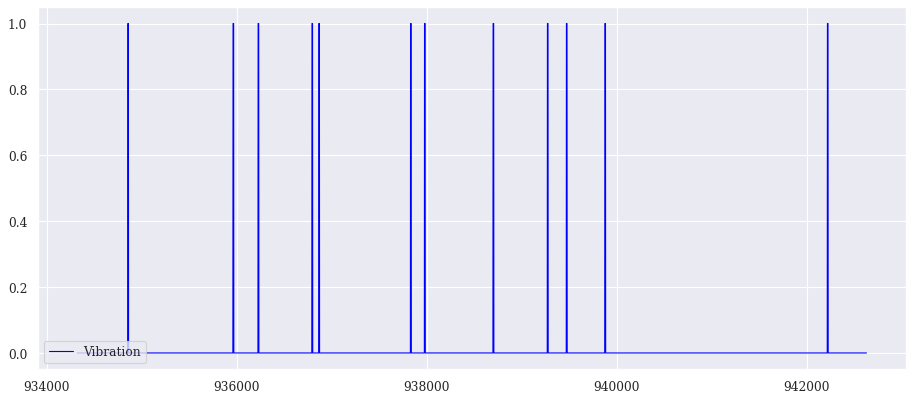

In [72]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(new_,  label='Vibration', color='blue', animated=True, linewidth=1)
ax.plot(d2['one'], label='Failure', color='red', marker='o', markersize=5, linestyle='none')
plt.legend(loc='lower left')
plt.show()

In [19]:
import datetime

def create_gbm_dataset(df, test=False):
    drop_cols = ['failure']

    target = df['failure']

    return df.drop(drop_cols, axis=1), target

def create_nn_dataset(df):
    dataset = []
    for ID in range(1, 101):
      df_len = df[df['machineID'] == ID].shape[0]

      for i in range(64, df_len - 64, 64):
        seq = torch.tensor(df[df['machineID'] == ID]['past_vib'].iloc[i]).float()
        target = torch.tensor(df[df['machineID'] == ID]['future_vib'].iloc[i])
    
        dataset.append((seq, target))
    return dataset

def data_split(df):
    train_size = int(len(df) * 0.75)
    val_size = (len(df) - train_size) // 2

    train_df = df[: train_size]
    val_df = df[train_size : train_size + val_size]
    test_df = df[train_size + val_size :]

    return train_df, val_df, test_df



In [ ]:
new_df['past_vib']

In [11]:
def train_loop(model, train_dataset, val_dataset, n_epochs, log_interval=5):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train_mean_losses=[], train_losses=[], val_mean_losses=[], val_loases=[], trains=[], vals=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for idx, (seq, label) in enumerate(train_dataset):
      optimizer.zero_grad()

      seq = seq.to(device)
      label = label.to(device)

      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

      pred = model(seq)
      loss = criterion(pred, label)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      history['trains'].append((seq, pred, label))

      if idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, idx, len(train_dataset),
            100. * idx / len(train_dataset), loss.item()))
        print(pred.shape)

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for (seq, label) in val_dataset:

        seq = seq.to(device)
        label = label.to(device)
        pred = model(seq)

        loss = criterion(pred, label)
        val_losses.append(loss.item())

        history['vals'].append((seq, pred, label))

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train_mean_losses'].append(train_loss)
    history['train_losses'].append(train_losses)
    history['val_mean_losses'].append(val_loss)
    history['val_loases'].append(val_losses)


    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

    def predict(self, input_seq):
        output = self.forward(input_seq)
        return output

In [26]:
def train_nn(n_epochs=20, log_interval=10):
    df = new_df
    train_df, val_df, test_df = data_split(create_nn_dataset(df))

    model = LSTM(output_size=64)
    model.to(device)

    model, history = train_loop(model, train_df, val_df, n_epochs=n_epochs, log_interval=log_interval)

    torch.save({'model_state_dict': model.state_dict()}, 'nn.hdf5')

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_nn(n_epochs=5, log_interval=1000)

Train Epoch: 1 [0/11253 (0%)]	Loss: 2969.479492
torch.Size([64])
Train Epoch: 1 [10/11253 (0%)]	Loss: 2521.414551
torch.Size([64])
Train Epoch: 1 [20/11253 (0%)]	Loss: 2552.895508
torch.Size([64])
Train Epoch: 1 [30/11253 (0%)]	Loss: 2412.299805
torch.Size([64])
Train Epoch: 1 [40/11253 (0%)]	Loss: 2275.843994
torch.Size([64])
Train Epoch: 1 [50/11253 (0%)]	Loss: 2230.012939
torch.Size([64])
Train Epoch: 1 [60/11253 (1%)]	Loss: 2143.734863
torch.Size([64])
Train Epoch: 1 [70/11253 (1%)]	Loss: 2126.094238
torch.Size([64])
Train Epoch: 1 [80/11253 (1%)]	Loss: 2037.584229
torch.Size([64])
Train Epoch: 1 [90/11253 (1%)]	Loss: 2649.091553
torch.Size([64])
Train Epoch: 1 [100/11253 (1%)]	Loss: 1795.193848
torch.Size([64])
Train Epoch: 1 [110/11253 (1%)]	Loss: 1768.060181
torch.Size([64])
Train Epoch: 1 [120/11253 (1%)]	Loss: 1640.427856
torch.Size([64])
Train Epoch: 1 [130/11253 (1%)]	Loss: 1557.182373
torch.Size([64])
Train Epoch: 1 [140/11253 (1%)]	Loss: 1563.302490
torch.Size([64])
Train 

Train Epoch: 1 [1270/11253 (11%)]	Loss: 265.405365
torch.Size([64])
Train Epoch: 1 [1280/11253 (11%)]	Loss: 507.492218
torch.Size([64])
Train Epoch: 1 [1290/11253 (11%)]	Loss: 268.291565
torch.Size([64])
Train Epoch: 1 [1300/11253 (12%)]	Loss: 261.050110
torch.Size([64])
Train Epoch: 1 [1310/11253 (12%)]	Loss: 273.354309
torch.Size([64])
Train Epoch: 1 [1320/11253 (12%)]	Loss: 276.486084
torch.Size([64])
Train Epoch: 1 [1330/11253 (12%)]	Loss: 220.326935
torch.Size([64])
Train Epoch: 1 [1340/11253 (12%)]	Loss: 248.982986
torch.Size([64])
Train Epoch: 1 [1350/11253 (12%)]	Loss: 287.460754
torch.Size([64])
Train Epoch: 1 [1360/11253 (12%)]	Loss: 283.032867
torch.Size([64])
Train Epoch: 1 [1370/11253 (12%)]	Loss: 277.146881
torch.Size([64])
Train Epoch: 1 [1380/11253 (12%)]	Loss: 238.551147
torch.Size([64])
Train Epoch: 1 [1390/11253 (12%)]	Loss: 217.824570
torch.Size([64])
Train Epoch: 1 [1400/11253 (12%)]	Loss: 287.128845
torch.Size([64])
Train Epoch: 1 [1410/11253 (13%)]	Loss: 284.4480

Train Epoch: 1 [2510/11253 (22%)]	Loss: 233.963821
torch.Size([64])
Train Epoch: 1 [2520/11253 (22%)]	Loss: 248.292572
torch.Size([64])
Train Epoch: 1 [2530/11253 (22%)]	Loss: 240.756699
torch.Size([64])
Train Epoch: 1 [2540/11253 (23%)]	Loss: 240.752258
torch.Size([64])
Train Epoch: 1 [2550/11253 (23%)]	Loss: 264.210327
torch.Size([64])
Train Epoch: 1 [2560/11253 (23%)]	Loss: 266.964478
torch.Size([64])
Train Epoch: 1 [2570/11253 (23%)]	Loss: 276.404938
torch.Size([64])
Train Epoch: 1 [2580/11253 (23%)]	Loss: 252.665146
torch.Size([64])
Train Epoch: 1 [2590/11253 (23%)]	Loss: 226.620285
torch.Size([64])
Train Epoch: 1 [2600/11253 (23%)]	Loss: 242.069901
torch.Size([64])
Train Epoch: 1 [2610/11253 (23%)]	Loss: 321.981018
torch.Size([64])
Train Epoch: 1 [2620/11253 (23%)]	Loss: 252.841583
torch.Size([64])
Train Epoch: 1 [2630/11253 (23%)]	Loss: 266.011414
torch.Size([64])
Train Epoch: 1 [2640/11253 (23%)]	Loss: 217.214569
torch.Size([64])
Train Epoch: 1 [2650/11253 (24%)]	Loss: 253.6981

Train Epoch: 1 [3740/11253 (33%)]	Loss: 254.130890
torch.Size([64])
Train Epoch: 1 [3750/11253 (33%)]	Loss: 243.470490
torch.Size([64])
Train Epoch: 1 [3760/11253 (33%)]	Loss: 349.130432
torch.Size([64])
Train Epoch: 1 [3770/11253 (34%)]	Loss: 293.441742
torch.Size([64])
Train Epoch: 1 [3780/11253 (34%)]	Loss: 262.086487
torch.Size([64])
Train Epoch: 1 [3790/11253 (34%)]	Loss: 240.315399
torch.Size([64])
Train Epoch: 1 [3800/11253 (34%)]	Loss: 522.637085
torch.Size([64])
Train Epoch: 1 [3810/11253 (34%)]	Loss: 275.268433
torch.Size([64])
Train Epoch: 1 [3820/11253 (34%)]	Loss: 300.293945
torch.Size([64])
Train Epoch: 1 [3830/11253 (34%)]	Loss: 259.017090
torch.Size([64])
Train Epoch: 1 [3840/11253 (34%)]	Loss: 410.966370
torch.Size([64])
Train Epoch: 1 [3850/11253 (34%)]	Loss: 297.605438
torch.Size([64])
Train Epoch: 1 [3860/11253 (34%)]	Loss: 244.976044
torch.Size([64])
Train Epoch: 1 [3870/11253 (34%)]	Loss: 255.768555
torch.Size([64])
Train Epoch: 1 [3880/11253 (34%)]	Loss: 225.2491

Train Epoch: 1 [4970/11253 (44%)]	Loss: 259.048035
torch.Size([64])
Train Epoch: 1 [4980/11253 (44%)]	Loss: 245.943924
torch.Size([64])
Train Epoch: 1 [4990/11253 (44%)]	Loss: 294.330292
torch.Size([64])
Train Epoch: 1 [5000/11253 (44%)]	Loss: 230.242920
torch.Size([64])
Train Epoch: 1 [5010/11253 (45%)]	Loss: 250.004517
torch.Size([64])
Train Epoch: 1 [5020/11253 (45%)]	Loss: 246.232819
torch.Size([64])
Train Epoch: 1 [5030/11253 (45%)]	Loss: 254.044846
torch.Size([64])
Train Epoch: 1 [5040/11253 (45%)]	Loss: 240.423523
torch.Size([64])
Train Epoch: 1 [5050/11253 (45%)]	Loss: 282.073975
torch.Size([64])
Train Epoch: 1 [5060/11253 (45%)]	Loss: 250.605377
torch.Size([64])
Train Epoch: 1 [5070/11253 (45%)]	Loss: 236.472534
torch.Size([64])
Train Epoch: 1 [5080/11253 (45%)]	Loss: 249.753174
torch.Size([64])
Train Epoch: 1 [5090/11253 (45%)]	Loss: 278.550232
torch.Size([64])
Train Epoch: 1 [5100/11253 (45%)]	Loss: 247.826126
torch.Size([64])
Train Epoch: 1 [5110/11253 (45%)]	Loss: 230.5944

Train Epoch: 1 [6230/11253 (55%)]	Loss: 277.164734
torch.Size([64])
Train Epoch: 1 [6240/11253 (55%)]	Loss: 251.066711
torch.Size([64])
Train Epoch: 1 [6250/11253 (56%)]	Loss: 307.722595
torch.Size([64])
Train Epoch: 1 [6260/11253 (56%)]	Loss: 276.965637
torch.Size([64])
Train Epoch: 1 [6270/11253 (56%)]	Loss: 267.647583
torch.Size([64])
Train Epoch: 1 [6280/11253 (56%)]	Loss: 237.462830
torch.Size([64])
Train Epoch: 1 [6290/11253 (56%)]	Loss: 278.594452
torch.Size([64])
Train Epoch: 1 [6300/11253 (56%)]	Loss: 269.930664
torch.Size([64])
Train Epoch: 1 [6310/11253 (56%)]	Loss: 399.084229
torch.Size([64])
Train Epoch: 1 [6320/11253 (56%)]	Loss: 235.426575
torch.Size([64])
Train Epoch: 1 [6330/11253 (56%)]	Loss: 244.738266
torch.Size([64])
Train Epoch: 1 [6340/11253 (56%)]	Loss: 239.115082
torch.Size([64])
Train Epoch: 1 [6350/11253 (56%)]	Loss: 244.737503
torch.Size([64])
Train Epoch: 1 [6360/11253 (57%)]	Loss: 246.327240
torch.Size([64])
Train Epoch: 1 [6370/11253 (57%)]	Loss: 256.1275

Train Epoch: 1 [7450/11253 (66%)]	Loss: 291.860168
torch.Size([64])
Train Epoch: 1 [7460/11253 (66%)]	Loss: 239.895172
torch.Size([64])
Train Epoch: 1 [7470/11253 (66%)]	Loss: 277.909912
torch.Size([64])
Train Epoch: 1 [7480/11253 (66%)]	Loss: 248.983047
torch.Size([64])
Train Epoch: 1 [7490/11253 (67%)]	Loss: 246.743210
torch.Size([64])
Train Epoch: 1 [7500/11253 (67%)]	Loss: 273.155853
torch.Size([64])
Train Epoch: 1 [7510/11253 (67%)]	Loss: 265.190674
torch.Size([64])
Train Epoch: 1 [7520/11253 (67%)]	Loss: 322.239166
torch.Size([64])
Train Epoch: 1 [7530/11253 (67%)]	Loss: 286.307373
torch.Size([64])
Train Epoch: 1 [7540/11253 (67%)]	Loss: 245.839523
torch.Size([64])
Train Epoch: 1 [7550/11253 (67%)]	Loss: 236.744919
torch.Size([64])
Train Epoch: 1 [7560/11253 (67%)]	Loss: 244.799454
torch.Size([64])
Train Epoch: 1 [7570/11253 (67%)]	Loss: 235.853699
torch.Size([64])
Train Epoch: 1 [7580/11253 (67%)]	Loss: 260.202301
torch.Size([64])
Train Epoch: 1 [7590/11253 (67%)]	Loss: 235.2419

Train Epoch: 1 [8710/11253 (77%)]	Loss: 281.413086
torch.Size([64])
Train Epoch: 1 [8720/11253 (77%)]	Loss: 295.239563
torch.Size([64])
Train Epoch: 1 [8730/11253 (78%)]	Loss: 224.401794
torch.Size([64])
Train Epoch: 1 [8740/11253 (78%)]	Loss: 259.487549
torch.Size([64])
Train Epoch: 1 [8750/11253 (78%)]	Loss: 270.021820
torch.Size([64])
Train Epoch: 1 [8760/11253 (78%)]	Loss: 293.001343
torch.Size([64])
Train Epoch: 1 [8770/11253 (78%)]	Loss: 209.750015
torch.Size([64])
Train Epoch: 1 [8780/11253 (78%)]	Loss: 254.699188
torch.Size([64])
Train Epoch: 1 [8790/11253 (78%)]	Loss: 252.685059
torch.Size([64])
Train Epoch: 1 [8800/11253 (78%)]	Loss: 297.274811
torch.Size([64])
Train Epoch: 1 [8810/11253 (78%)]	Loss: 255.503693
torch.Size([64])
Train Epoch: 1 [8820/11253 (78%)]	Loss: 241.579376
torch.Size([64])
Train Epoch: 1 [8830/11253 (78%)]	Loss: 251.811081
torch.Size([64])
Train Epoch: 1 [8840/11253 (79%)]	Loss: 273.505859
torch.Size([64])
Train Epoch: 1 [8850/11253 (79%)]	Loss: 298.4218

Train Epoch: 1 [9930/11253 (88%)]	Loss: 272.797455
torch.Size([64])
Train Epoch: 1 [9940/11253 (88%)]	Loss: 250.195801
torch.Size([64])
Train Epoch: 1 [9950/11253 (88%)]	Loss: 311.074371
torch.Size([64])
Train Epoch: 1 [9960/11253 (89%)]	Loss: 229.982849
torch.Size([64])
Train Epoch: 1 [9970/11253 (89%)]	Loss: 288.273315
torch.Size([64])
Train Epoch: 1 [9980/11253 (89%)]	Loss: 248.557114
torch.Size([64])
Train Epoch: 1 [9990/11253 (89%)]	Loss: 247.178345
torch.Size([64])
Train Epoch: 1 [10000/11253 (89%)]	Loss: 350.996887
torch.Size([64])
Train Epoch: 1 [10010/11253 (89%)]	Loss: 250.982895
torch.Size([64])
Train Epoch: 1 [10020/11253 (89%)]	Loss: 265.910034
torch.Size([64])
Train Epoch: 1 [10030/11253 (89%)]	Loss: 249.493347
torch.Size([64])
Train Epoch: 1 [10040/11253 (89%)]	Loss: 251.368927
torch.Size([64])
Train Epoch: 1 [10050/11253 (89%)]	Loss: 271.111908
torch.Size([64])
Train Epoch: 1 [10060/11253 (89%)]	Loss: 236.070892
torch.Size([64])
Train Epoch: 1 [10070/11253 (89%)]	Loss: 

Train Epoch: 1 [11120/11253 (99%)]	Loss: 310.359772
torch.Size([64])
Train Epoch: 1 [11130/11253 (99%)]	Loss: 233.054153
torch.Size([64])
Train Epoch: 1 [11140/11253 (99%)]	Loss: 228.772461
torch.Size([64])
Train Epoch: 1 [11150/11253 (99%)]	Loss: 257.452942
torch.Size([64])
Train Epoch: 1 [11160/11253 (99%)]	Loss: 215.929779
torch.Size([64])
Train Epoch: 1 [11170/11253 (99%)]	Loss: 258.489624
torch.Size([64])
Train Epoch: 1 [11180/11253 (99%)]	Loss: 244.796600
torch.Size([64])
Train Epoch: 1 [11190/11253 (99%)]	Loss: 235.720551
torch.Size([64])
Train Epoch: 1 [11200/11253 (100%)]	Loss: 220.991760
torch.Size([64])
Train Epoch: 1 [11210/11253 (100%)]	Loss: 254.526596
torch.Size([64])
Train Epoch: 1 [11220/11253 (100%)]	Loss: 248.776123
torch.Size([64])
Train Epoch: 1 [11230/11253 (100%)]	Loss: 323.575623
torch.Size([64])
Train Epoch: 1 [11240/11253 (100%)]	Loss: 292.643860
torch.Size([64])
Train Epoch: 1 [11250/11253 (100%)]	Loss: 227.177841
torch.Size([64])
Epoch 1: train loss 304.8998

Train Epoch: 2 [1100/11253 (10%)]	Loss: 478.554260
torch.Size([64])
Train Epoch: 2 [1110/11253 (10%)]	Loss: 292.975342
torch.Size([64])
Train Epoch: 2 [1120/11253 (10%)]	Loss: 362.615387
torch.Size([64])
Train Epoch: 2 [1130/11253 (10%)]	Loss: 238.666840
torch.Size([64])
Train Epoch: 2 [1140/11253 (10%)]	Loss: 269.609985
torch.Size([64])
Train Epoch: 2 [1150/11253 (10%)]	Loss: 269.978912
torch.Size([64])
Train Epoch: 2 [1160/11253 (10%)]	Loss: 273.657288
torch.Size([64])
Train Epoch: 2 [1170/11253 (10%)]	Loss: 251.869232
torch.Size([64])
Train Epoch: 2 [1180/11253 (10%)]	Loss: 273.504333
torch.Size([64])
Train Epoch: 2 [1190/11253 (11%)]	Loss: 268.797577
torch.Size([64])
Train Epoch: 2 [1200/11253 (11%)]	Loss: 287.913910
torch.Size([64])
Train Epoch: 2 [1210/11253 (11%)]	Loss: 275.679810
torch.Size([64])
Train Epoch: 2 [1220/11253 (11%)]	Loss: 231.374695
torch.Size([64])
Train Epoch: 2 [1230/11253 (11%)]	Loss: 310.203552
torch.Size([64])
Train Epoch: 2 [1240/11253 (11%)]	Loss: 238.9509

Train Epoch: 2 [2340/11253 (21%)]	Loss: 265.028229
torch.Size([64])
Train Epoch: 2 [2350/11253 (21%)]	Loss: 253.733582
torch.Size([64])
Train Epoch: 2 [2360/11253 (21%)]	Loss: 481.736908
torch.Size([64])
Train Epoch: 2 [2370/11253 (21%)]	Loss: 245.038940
torch.Size([64])
Train Epoch: 2 [2380/11253 (21%)]	Loss: 225.041092
torch.Size([64])
Train Epoch: 2 [2390/11253 (21%)]	Loss: 294.792511
torch.Size([64])
Train Epoch: 2 [2400/11253 (21%)]	Loss: 227.562775
torch.Size([64])
Train Epoch: 2 [2410/11253 (21%)]	Loss: 198.008606
torch.Size([64])
Train Epoch: 2 [2420/11253 (22%)]	Loss: 198.594238
torch.Size([64])
Train Epoch: 2 [2430/11253 (22%)]	Loss: 259.857635
torch.Size([64])
Train Epoch: 2 [2440/11253 (22%)]	Loss: 288.327087
torch.Size([64])
Train Epoch: 2 [2450/11253 (22%)]	Loss: 261.981018
torch.Size([64])
Train Epoch: 2 [2460/11253 (22%)]	Loss: 472.245575
torch.Size([64])
Train Epoch: 2 [2470/11253 (22%)]	Loss: 224.983368
torch.Size([64])
Train Epoch: 2 [2480/11253 (22%)]	Loss: 264.7325

Train Epoch: 2 [3600/11253 (32%)]	Loss: 242.360291
torch.Size([64])
Train Epoch: 2 [3610/11253 (32%)]	Loss: 267.409424
torch.Size([64])
Train Epoch: 2 [3620/11253 (32%)]	Loss: 270.427673
torch.Size([64])
Train Epoch: 2 [3630/11253 (32%)]	Loss: 263.468140
torch.Size([64])
Train Epoch: 2 [3640/11253 (32%)]	Loss: 288.936310
torch.Size([64])
Train Epoch: 2 [3650/11253 (32%)]	Loss: 224.747940
torch.Size([64])
Train Epoch: 2 [3660/11253 (33%)]	Loss: 238.670654
torch.Size([64])
Train Epoch: 2 [3670/11253 (33%)]	Loss: 285.541809
torch.Size([64])
Train Epoch: 2 [3680/11253 (33%)]	Loss: 540.411926
torch.Size([64])
Train Epoch: 2 [3690/11253 (33%)]	Loss: 287.805786
torch.Size([64])
Train Epoch: 2 [3700/11253 (33%)]	Loss: 256.685181
torch.Size([64])
Train Epoch: 2 [3710/11253 (33%)]	Loss: 232.612076
torch.Size([64])
Train Epoch: 2 [3720/11253 (33%)]	Loss: 273.076141
torch.Size([64])
Train Epoch: 2 [3730/11253 (33%)]	Loss: 534.373535
torch.Size([64])
Train Epoch: 2 [3740/11253 (33%)]	Loss: 254.2666

Train Epoch: 2 [4810/11253 (43%)]	Loss: 244.992340
torch.Size([64])
Train Epoch: 2 [4820/11253 (43%)]	Loss: 256.937378
torch.Size([64])
Train Epoch: 2 [4830/11253 (43%)]	Loss: 305.833740
torch.Size([64])
Train Epoch: 2 [4840/11253 (43%)]	Loss: 291.363708
torch.Size([64])
Train Epoch: 2 [4850/11253 (43%)]	Loss: 299.115356
torch.Size([64])
Train Epoch: 2 [4860/11253 (43%)]	Loss: 282.383789
torch.Size([64])
Train Epoch: 2 [4870/11253 (43%)]	Loss: 299.321899
torch.Size([64])
Train Epoch: 2 [4880/11253 (43%)]	Loss: 229.815186
torch.Size([64])
Train Epoch: 2 [4890/11253 (43%)]	Loss: 247.066833
torch.Size([64])
Train Epoch: 2 [4900/11253 (44%)]	Loss: 275.435638
torch.Size([64])
Train Epoch: 2 [4910/11253 (44%)]	Loss: 241.241241
torch.Size([64])
Train Epoch: 2 [4920/11253 (44%)]	Loss: 280.451111
torch.Size([64])
Train Epoch: 2 [4930/11253 (44%)]	Loss: 233.881409
torch.Size([64])
Train Epoch: 2 [4940/11253 (44%)]	Loss: 227.666733
torch.Size([64])
Train Epoch: 2 [4950/11253 (44%)]	Loss: 244.9522

Train Epoch: 2 [6070/11253 (54%)]	Loss: 243.046631
torch.Size([64])
Train Epoch: 2 [6080/11253 (54%)]	Loss: 270.913696
torch.Size([64])
Train Epoch: 2 [6090/11253 (54%)]	Loss: 234.227280
torch.Size([64])
Train Epoch: 2 [6100/11253 (54%)]	Loss: 334.138123
torch.Size([64])
Train Epoch: 2 [6110/11253 (54%)]	Loss: 250.726822
torch.Size([64])
Train Epoch: 2 [6120/11253 (54%)]	Loss: 247.015137
torch.Size([64])
Train Epoch: 2 [6130/11253 (54%)]	Loss: 253.985443
torch.Size([64])
Train Epoch: 2 [6140/11253 (55%)]	Loss: 246.861755
torch.Size([64])
Train Epoch: 2 [6150/11253 (55%)]	Loss: 251.770889
torch.Size([64])
Train Epoch: 2 [6160/11253 (55%)]	Loss: 235.051086
torch.Size([64])
Train Epoch: 2 [6170/11253 (55%)]	Loss: 222.734711
torch.Size([64])
Train Epoch: 2 [6180/11253 (55%)]	Loss: 232.951752
torch.Size([64])
Train Epoch: 2 [6190/11253 (55%)]	Loss: 294.156403
torch.Size([64])
Train Epoch: 2 [6200/11253 (55%)]	Loss: 265.981079
torch.Size([64])
Train Epoch: 2 [6210/11253 (55%)]	Loss: 212.9454

Train Epoch: 2 [7280/11253 (65%)]	Loss: 231.157837
torch.Size([64])
Train Epoch: 2 [7290/11253 (65%)]	Loss: 277.967834
torch.Size([64])
Train Epoch: 2 [7300/11253 (65%)]	Loss: 209.161041
torch.Size([64])
Train Epoch: 2 [7310/11253 (65%)]	Loss: 246.521591
torch.Size([64])
Train Epoch: 2 [7320/11253 (65%)]	Loss: 261.840515
torch.Size([64])
Train Epoch: 2 [7330/11253 (65%)]	Loss: 234.679779
torch.Size([64])
Train Epoch: 2 [7340/11253 (65%)]	Loss: 272.931824
torch.Size([64])
Train Epoch: 2 [7350/11253 (65%)]	Loss: 295.817383
torch.Size([64])
Train Epoch: 2 [7360/11253 (65%)]	Loss: 246.614304
torch.Size([64])
Train Epoch: 2 [7370/11253 (65%)]	Loss: 244.151733
torch.Size([64])
Train Epoch: 2 [7380/11253 (66%)]	Loss: 244.144012
torch.Size([64])
Train Epoch: 2 [7390/11253 (66%)]	Loss: 243.072845
torch.Size([64])
Train Epoch: 2 [7400/11253 (66%)]	Loss: 250.774506
torch.Size([64])
Train Epoch: 2 [7410/11253 (66%)]	Loss: 242.313568
torch.Size([64])
Train Epoch: 2 [7420/11253 (66%)]	Loss: 271.0256

Train Epoch: 2 [8520/11253 (76%)]	Loss: 249.817001
torch.Size([64])
Train Epoch: 2 [8530/11253 (76%)]	Loss: 243.018494
torch.Size([64])
Train Epoch: 2 [8540/11253 (76%)]	Loss: 227.977325
torch.Size([64])
Train Epoch: 2 [8550/11253 (76%)]	Loss: 238.076416
torch.Size([64])
Train Epoch: 2 [8560/11253 (76%)]	Loss: 305.649139
torch.Size([64])
Train Epoch: 2 [8570/11253 (76%)]	Loss: 274.309021
torch.Size([64])
Train Epoch: 2 [8580/11253 (76%)]	Loss: 240.292969
torch.Size([64])
Train Epoch: 2 [8590/11253 (76%)]	Loss: 278.328491
torch.Size([64])
Train Epoch: 2 [8600/11253 (76%)]	Loss: 290.031311
torch.Size([64])
Train Epoch: 2 [8610/11253 (77%)]	Loss: 232.701263
torch.Size([64])
Train Epoch: 2 [8620/11253 (77%)]	Loss: 232.908386
torch.Size([64])
Train Epoch: 2 [8630/11253 (77%)]	Loss: 277.457275
torch.Size([64])
Train Epoch: 2 [8640/11253 (77%)]	Loss: 260.082703
torch.Size([64])
Train Epoch: 2 [8650/11253 (77%)]	Loss: 212.478546
torch.Size([64])
Train Epoch: 2 [8660/11253 (77%)]	Loss: 517.7016

Train Epoch: 2 [9740/11253 (87%)]	Loss: 277.000549
torch.Size([64])
Train Epoch: 2 [9750/11253 (87%)]	Loss: 268.198303
torch.Size([64])
Train Epoch: 2 [9760/11253 (87%)]	Loss: 230.390778
torch.Size([64])
Train Epoch: 2 [9770/11253 (87%)]	Loss: 283.622101
torch.Size([64])
Train Epoch: 2 [9780/11253 (87%)]	Loss: 257.872803
torch.Size([64])
Train Epoch: 2 [9790/11253 (87%)]	Loss: 245.271103
torch.Size([64])
Train Epoch: 2 [9800/11253 (87%)]	Loss: 286.730286
torch.Size([64])
Train Epoch: 2 [9810/11253 (87%)]	Loss: 269.573730
torch.Size([64])
Train Epoch: 2 [9820/11253 (87%)]	Loss: 240.454147
torch.Size([64])
Train Epoch: 2 [9830/11253 (87%)]	Loss: 227.925507
torch.Size([64])
Train Epoch: 2 [9840/11253 (87%)]	Loss: 272.414612
torch.Size([64])
Train Epoch: 2 [9850/11253 (88%)]	Loss: 241.138641
torch.Size([64])
Train Epoch: 2 [9860/11253 (88%)]	Loss: 256.782684
torch.Size([64])
Train Epoch: 2 [9870/11253 (88%)]	Loss: 238.970154
torch.Size([64])
Train Epoch: 2 [9880/11253 (88%)]	Loss: 254.0524

Train Epoch: 2 [10940/11253 (97%)]	Loss: 255.994263
torch.Size([64])
Train Epoch: 2 [10950/11253 (97%)]	Loss: 212.044678
torch.Size([64])
Train Epoch: 2 [10960/11253 (97%)]	Loss: 465.124634
torch.Size([64])
Train Epoch: 2 [10970/11253 (97%)]	Loss: 254.110580
torch.Size([64])
Train Epoch: 2 [10980/11253 (98%)]	Loss: 249.867371
torch.Size([64])
Train Epoch: 2 [10990/11253 (98%)]	Loss: 332.432678
torch.Size([64])
Train Epoch: 2 [11000/11253 (98%)]	Loss: 256.425903
torch.Size([64])
Train Epoch: 2 [11010/11253 (98%)]	Loss: 263.484070
torch.Size([64])
Train Epoch: 2 [11020/11253 (98%)]	Loss: 248.740692
torch.Size([64])
Train Epoch: 2 [11030/11253 (98%)]	Loss: 264.789703
torch.Size([64])
Train Epoch: 2 [11040/11253 (98%)]	Loss: 257.067017
torch.Size([64])
Train Epoch: 2 [11050/11253 (98%)]	Loss: 267.021912
torch.Size([64])
Train Epoch: 2 [11060/11253 (98%)]	Loss: 309.488647
torch.Size([64])
Train Epoch: 2 [11070/11253 (98%)]	Loss: 275.576477
torch.Size([64])
Train Epoch: 2 [11080/11253 (98%)]

In [10]:
def train_gbm(df, n_epochs=1000):
    x, y = create_gbm_dataset(df)
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.9)

    model = CatBoostClassifier(
        iterations=n_epochs, 
        learning_rate=0.01
        )

    model.fit(xtrain, ytrain, eval_set=(xtest, ytest))

    model.save_model('gbm.cbm')

In [20]:
train_gbm(new_df.drop(['machineID', 'datetime', 'model'], axis=1), 100)

0:	learn: 1.5746303	test: 1.5745663	best: 1.5745663 (0)	total: 1.49s	remaining: 2m 27s
1:	learn: 1.5414583	test: 1.5413321	best: 1.5413321 (1)	total: 3.01s	remaining: 2m 27s
2:	learn: 1.5097925	test: 1.5096073	best: 1.5096073 (2)	total: 4.39s	remaining: 2m 22s
3:	learn: 1.4794999	test: 1.4792565	best: 1.4792565 (3)	total: 5.63s	remaining: 2m 15s
4:	learn: 1.4504665	test: 1.4501713	best: 1.4501713 (4)	total: 6.97s	remaining: 2m 12s
5:	learn: 1.4226501	test: 1.4223005	best: 1.4223005 (5)	total: 8.55s	remaining: 2m 14s
6:	learn: 1.3959266	test: 1.3955251	best: 1.3955251 (6)	total: 9.45s	remaining: 2m 5s
7:	learn: 1.3702408	test: 1.3697888	best: 1.3697888 (7)	total: 11.4s	remaining: 2m 10s
8:	learn: 1.3455268	test: 1.3450274	best: 1.3450274 (8)	total: 12.7s	remaining: 2m 8s
9:	learn: 1.3217320	test: 1.3211820	best: 1.3211820 (9)	total: 14.4s	remaining: 2m 9s
10:	learn: 1.2987638	test: 1.2981644	best: 1.2981644 (10)	total: 15.8s	remaining: 2m 7s
11:	learn: 1.2764644	test: 1.2758218	best: 1.

93:	learn: 0.5182667	test: 0.5156201	best: 0.5156201 (93)	total: 2m 23s	remaining: 9.19s
94:	learn: 0.5143753	test: 0.5117215	best: 0.5117215 (94)	total: 2m 25s	remaining: 7.64s
95:	learn: 0.5105068	test: 0.5078503	best: 0.5078503 (95)	total: 2m 26s	remaining: 6.12s
96:	learn: 0.5066955	test: 0.5040279	best: 0.5040279 (96)	total: 2m 28s	remaining: 4.61s
97:	learn: 0.5029421	test: 0.5002516	best: 0.5002516 (97)	total: 2m 30s	remaining: 3.08s
98:	learn: 0.4992918	test: 0.4965865	best: 0.4965865 (98)	total: 2m 32s	remaining: 1.54s
99:	learn: 0.4954988	test: 0.4927770	best: 0.4927770 (99)	total: 2m 34s	remaining: 0us

bestTest = 0.4927770051
bestIteration = 99



In [22]:
def draw_tp(f, t, g, fl, tl, gl, ss, ls):
  fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
  ax.plot(range(0, ss), f, label=fl, color='blue', animated=True, linewidth=1)
  ax.plot(range(ss, ss+ls), t, label=tl, color='red', animated=True, linewidth=1)
  ax.plot(range(ss, ss+ls), g, label=gl, color='green', animated=True, linewidth=1)
  plt.legend(loc='lower left')
  plt.show()

In [23]:
def data_to_draw(data):
  return data.cpu().detach().tolist()

In [25]:
def draw_vibrations(data, n):
  draw_tp(data_to_draw(data[n][0]), data_to_draw(data[n][1]), data_to_draw(data[n][2]), 'Input', 'Predicted', 'Target', 64, 64)

In [ ]:
draw_vibrations(history['vals'], 3003)